In [31]:
##q2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import seaborn
user_df = pd.read_csv('q2_user_table.csv')
user_df.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [32]:
result_df = pd.read_csv('q2_test_results.csv')
result_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


# EDA

##### To avoid missing data, I will keep the dataset separated for now

In [33]:
user_df.isnull().sum()

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

In [34]:
result_df.isnull().sum()

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

In [35]:
result_df.groupby('test')['converted'].describe()

,count,mean,std,min,25%,50%,75%,max
test,,,,,,,,
0,202727.0,0.019904,0.139669,0.0,0.0,0.0,0.0,1.0
1,114073.0,0.015543,0.123698,0.0,0.0,0.0,0.0,1.0


##### There is a huge difference between two groups. ~1.9% of the customers buy the product in the low price groups vs. 1.5% of the customers in the high price group


In [36]:
#Total revenue if the price = $39
x = result_df.shape[0]
Income_39 = 39*x*0.019904
print('Income with $39: ', Income_39)
#Total revenue if the price = $59
Income_59 = 59*x*0.015543
print('Income with $59: ', Income_59 )
print('Income increase %: ',(Income_59-Income_39)/Income_59*100)

Income with $39:  245917.90080000003
Income with $59:  290517.32159999997
Income increase %:  15.351725175756245


##### Error:The data is inconsistent. Different test groups don't have a similar testing price distribution. The size of the error data is not significant and unclear on the cause; therefore, deleting these entries may be appropriate.

In [37]:
result_df[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

In [38]:
test_group_zero = result_df[(result_df['test'] == 0) & (result_df['price'] == 39)] 
test_group_one = result_df[(result_df['test'] == 1) & (result_df['price'] == 59)] 
clean_test_data = pd.concat([test_group_zero,test_group_one] )
clean_test_data[['price', 'test', 'user_id']].groupby(['test', 'price']).count()
##error is correct

,,user_id
test,price,
0,39,202517
1,59,113918


In [39]:
##conversion
clean_test_data[['price', 'converted', 'user_id']].groupby(['price', 'converted']).count()

user_id
price converted         
39    0           198487
      1             4030
59    0           112146
      1             1772

##### merge the two data frames

In [40]:
combined_data = pd.merge(clean_test_data, user_df, on='user_id', how='left')
combined_data

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02
4,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39,0,New York,USA,40.67,-73.94
...,...,...,...,...,...,...,...,...,...,...,...,...
316430,190563,2015-05-17 12:03:19,seo_facebook,mobile,android,1,59,0,New Haven,USA,41.31,-72.92
316431,796427,2015-04-02 09:33:18,seo-google,web,windows,1,59,0,Norwalk,USA,33.91,-118.08
316432,964001,2015-05-05 13:31:19,ads_other,web,windows,1,59,0,Athens-Clarke,USA,33.95,-83.39
316433,388438,2015-05-20 11:34:44,seo-google,web,windows,1,59,0,Joliet,USA,41.53,-88.12


In [41]:
##Real income calculation
##no income if converted = 0
combined_data['income'] = combined_data['price'] * combined_data['converted']
combined_data[['test', 'income']].groupby('test').mean()

,income
test,
0,0.776083
1,0.917748


In [42]:
##mean of conversion
combined_data[['test', 'converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [43]:
##evaluate the variance for both group
import statistics 
var_group_zero = statistics.variance(combined_data[combined_data['test']== 0]['income'])
var_group_one = statistics.variance(combined_data[combined_data['test']== 1]['income'])
print("variance for group zero: ", var_group_zero)
print("variance for group one: ",var_group_one)

variance for group zero:  29.665078490573645
variance for group one:  53.305330173629486


##### AB test on the mean of income for both group

 Assumption: Null hypothesis H0: the average income of group zero(test=0) ≥ avearge income of group one (test=1)

In [44]:
from scipy.stats import ttest_ind
print(ttest_ind(combined_data[combined_data['test']== 0]['income'], combined_data[combined_data['test'] == 1]['income'], axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)


We can reject the Null hypothesis because the p-value < 0.05. 
In conclusion, the average income of group zero is less than that of group one.

# user behaviour

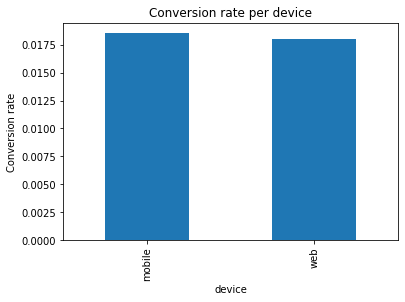

mobile users% : 0.588642217201005
         count      mean       std  min  25%  50%  75%  max
test                                                       
0     202517.0  0.019900  0.139656  0.0  0.0  0.0  0.0  1.0
1     113918.0  0.015555  0.123747  0.0  0.0  0.0  0.0  1.0
             converted
device test           
mobile 0      0.019872
       1      0.016146
web    0      0.019940
       1      0.014744


In [45]:
#Conversion rate by device
combined_data.groupby("device")["converted"].mean().plot(kind='bar')
plt.ylabel('Conversion rate')
plt.xlabel('device')
plt.title('Conversion rate per device')
plt.show()
print('mobile users% :',combined_data[combined_data['device']=='mobile'].shape[0]/combined_data.shape[0])
print(combined_data.groupby('test')['converted'].describe())
print(combined_data.groupby(['device','test']).agg({'converted':'mean'}))

As it has relatively higher percentage on mobile user, what will happen if we increase price for mobile user only?

In [46]:
x = combined_data.shape[0]
income_39 = 39*x*0.019900
print('Income with $39: ', income_39)
income_59 = 39*x*0.019940*(1-0.588) + 59*x*0.016146*0.588
print('income with $59 if we increase the price only in mobile users', income_59)
print('income% increase :',(income_59-income_39)/income_59*100)

Income with $39:  245585.2035
income with $59 if we increase the price only in mobile users 278631.44466612
income% increase : 11.860198049692066


11% impact of income on increasing the price only in mobile users v.s. ~15% impact of income overall
In summary, increase the price only in mobile users doesnt help.

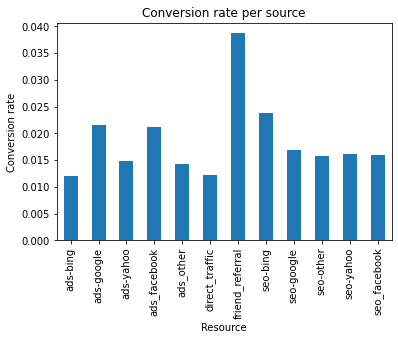

count      mean       std  min  25%  50%  75%  max
source          test                                                      
ads-bing        0     14584.0  0.013371  0.114861  0.0  0.0  0.0  0.0  1.0
                1      8247.0  0.009579  0.097410  0.0  0.0  0.0  0.0  1.0
ads-google      0     37845.0  0.022566  0.148516  0.0  0.0  0.0  0.0  1.0
                1     21497.0  0.019631  0.138731  0.0  0.0  0.0  0.0  1.0
ads-yahoo       0      4812.0  0.016833  0.128659  0.0  0.0  0.0  0.0  1.0
                1      2759.0  0.011236  0.105422  0.0  0.0  0.0  0.0  1.0
ads_facebook    0     34074.0  0.023654  0.151972  0.0  0.0  0.0  0.0  1.0
                1     19281.0  0.016856  0.128735  0.0  0.0  0.0  0.0  1.0
ads_other       0     19256.0  0.015424  0.123234  0.0  0.0  0.0  0.0  1.0
                1     10570.0  0.012394  0.110640  0.0  0.0  0.0  0.0  1.0
direct_traffic  0     38712.0  0.013510  0.115446  0.0  0.0  0.0  0.0  1.0
                1     21560.0  0.010111  0.100048  0.0  0.0  0.0  0.0  1.0
friend_referral 0     13121.0  0.041689  0.199885  0.0  0.0  0.0  0.0  1.0
                1      7557.0  0.033479  0.179895  0.0  0.0  0.0  0.0  1.0
seo-bing        0      1329.0  0.030098  0.170921  0.0  0.0  0.0  0.0  1.0
                1       815.0  0.013497  0.115460  0.0  0.0  0.0  0.0  1.0
seo-google      0     15088.0  0.017497  0.131120  0.0  0.0  0.0  0.0  1.0
                1      8060.0  0.016005  0.125502  0.0  0.0  0.0  0.0  1.0
seo-other       0      5879.0  0.017520  0.131210  0.0  0.0  0.0  0.0  1.0
                1      3365.0  0.012481  0.111037  0.0  0.0  0.0  0.0  1.0
seo-yahoo       0      4356.0  0.019513  0.138336  0.0  0.0  0.0  0.0  1.0
                1      2485.0  0.010463  0.101772  0.0  0.0  0.0  0.0  1.0
seo_facebook    0     13461.0  0.017458  0.130975  0.0  0.0  0.0  0.0  1.0
                1      7722.0  0.013598  0.115820  0.0  0.0  0.0  0.0  1.0

In [47]:
#Conversion rate by source
sourceplot = combined_data.groupby("source")["converted"].mean().plot(kind='bar')
plt.ylabel('Conversion rate')
plt.xlabel('Resource')
plt.title('Conversion rate per source')
plt.show()
combined_data.groupby(['source','test'])['converted'].describe()

percent decrease in conversion rate between both test group is lowest in seo-bing users
However, as the group is at thesmall percentage it wouldn't make huge difference if increase the price on this group.

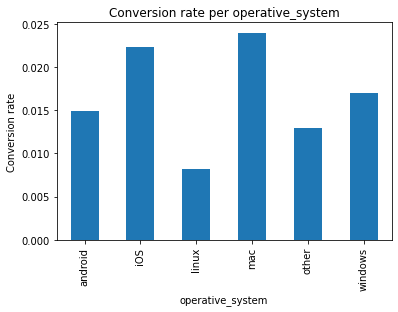

count      mean       std  min  25%  50%  75%  max
operative_system test                                                      
android          0     48177.0  0.016336  0.126764  0.0  0.0  0.0  0.0  1.0
                 1     26693.0  0.012363  0.110501  0.0  0.0  0.0  0.0  1.0
iOS              0     61793.0  0.023595  0.151785  0.0  0.0  0.0  0.0  1.0
                 1     33560.0  0.019994  0.139982  0.0  0.0  0.0  0.0  1.0
linux            0      2204.0  0.015426  0.123270  0.0  0.0  0.0  0.0  1.0
                 1      1926.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
mac              0     16345.0  0.025451  0.157496  0.0  0.0  0.0  0.0  1.0
                 1      8710.0  0.021240  0.144192  0.0  0.0  0.0  0.0  1.0
other            0     10481.0  0.014025  0.117601  0.0  0.0  0.0  0.0  1.0
                 1      5696.0  0.011060  0.104594  0.0  0.0  0.0  0.0  1.0
windows          0     63517.0  0.018704  0.135477  0.0  0.0  0.0  0.0  1.0
                 1     37333.0  0.014009  0.117529  0.0  0.0  0.0  0.0  1.0

In [48]:
#Conversion rate by operating system
sourceplot = combined_data.groupby("operative_system")["converted"].mean().plot(kind='bar')
plt.ylabel('Conversion rate')
plt.xlabel('operative_system')
plt.title('Conversion rate per operative_system')
plt.show()
combined_data.groupby(['operative_system','test'])['converted'].describe()

Mac and ios user has relatively higher conversion rate

['USA' nan]
61.18
19.7
30.31
-157.8


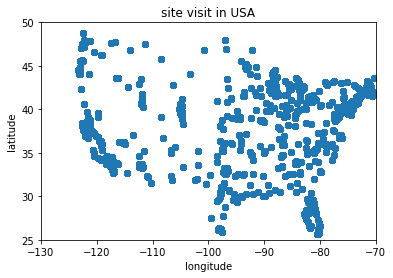

In [49]:
#Conversion rate by user location
print(combined_data['country'].unique())
print(combined_data.loc[combined_data['country']=='USA','lat'].max())
print(combined_data.loc[combined_data['country']=='USA','lat'].min())
print(combined_data.loc[combined_data['country']=='USA','long'].max())
print(combined_data.loc[combined_data['country']=='USA','long'].min())

plt.scatter(combined_data.loc[combined_data['country']=='USA','long'],combined_data.loc[combined_data['country']=='USA','lat'])
plt.xlim([-130,-70])
plt.ylim([25,50])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('site visit in USA')
plt.show()

[50.  47.5 45.  42.5 40.  37.5 35.  32.5 30.  27.5]
[-130 -125 -120 -115 -110 -105 -100  -95  -90  -85  -80  -75]


D:\python\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\python\anaconda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


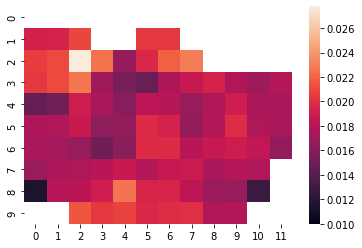

In [50]:
import seaborn as sns
lat = np.arange(50,25,-2.5)
long= np.arange(-130,-70,5)
print(lat)
print(long)
lat_long = np.zeros(shape=(len(lat),len(long)))
for i in range(len(lat)):
    for j in range(len(long)):
        a = lat[i]
        b = long[j]
        df4 = combined_data.loc[(combined_data['country']=='USA')]
        df4 = df4[(a < df4['lat'])& (df4['lat'] < a + 5)]
        df4 = df4[(b < df4['long'])&(df4['long'] < b + 10)]
        lat_long[i][j]=np.nanmean(df4['converted'])
ax = sns.heatmap(lat_long,vmin=0.010)

Summary:geographical location will also impact the conversion rate and the price accecpbility.
At places where conversion rate is highest, maybe we can also afford much higher prices

# What is your recommendation to the company in terms of setting an optimum price for their product?

In [51]:
##### Selling products at $39 is a better choice for the user conversion rate as calculated before (1.9% v.s. 1.5%).
#However, the higher unit price will bring extra income for the organization. 
#I will recommend sticking to the $39 price 
##but incrementing the conversion rate based on the users' behaviours.

# Can you optimize the number of days that the test is run? After how many days would you have stopped the test? Why?

In [52]:
print("Start of experiment: ",min(combined_data['timestamp']))
print("End of experiment: ",max(combined_data['timestamp']))

Start of experiment:  2015-03-02 00:04:12
End of experiment:  2015-05-31 23:59:45


Compared to the z-test, 
t-test tells more on the statistically significant difference 
between two independent sample groups.As there is a variance differnce in two samples, I will use the welch's t-test here.

In [53]:
##if one month for test
##Use ttest_ind to calculate the T-test for the means of two independent samples of scores.
zero_test = combined_data[(combined_data['test'] == 0) & (combined_data['timestamp'] < '2015-04-02') ]['income'].values
one_test = combined_data[(combined_data['test'] == 1) & (combined_data['timestamp'] < '2015-04-02')]['income'].values
#Welch's t-test
print(ttest_ind(zero_test, one_test, axis=0, equal_var=False))

Ttest_indResult(statistic=-4.15414211702349, pvalue=3.2696683365610206e-05)


In [54]:
#significance with p < 0.05
##test for half of the month
zero_test = combined_data[(combined_data['test'] == 0) & (combined_data['timestamp'] < '2015-03-17') ]['income'].values
one_test = combined_data[(combined_data['test'] == 1) & (combined_data['timestamp'] < '2015-03-17')]['income'].values
#Welch's t-test
print(ttest_ind(zero_test, one_test, axis=0, equal_var=False))

Ttest_indResult(statistic=-3.0914390981161657, pvalue=0.001993798324195856)


In [55]:
##Dichotomy
zero_test = combined_data[(combined_data['test'] == 0) & (combined_data['timestamp'] < '2015-03-09') ]['income'].values
one_test = combined_data[(combined_data['test'] == 1) & (combined_data['timestamp'] < '2015-03-09')]['income'].values
#Welch's t-test
print(ttest_ind(zero_test, one_test, axis=0, equal_var=False))

Ttest_indResult(statistic=-2.153549702517795, pvalue=0.031291794023264104)


In [56]:
##Dichotomy
zero_test = combined_data[(combined_data['test'] == 0) & (combined_data['timestamp'] < '2015-03-04') ]['income'].values
one_test = combined_data[(combined_data['test'] == 1) & (combined_data['timestamp'] < '2015-03-04')]['income'].values
#Welch's t-test
print(ttest_ind(zero_test, one_test, axis=0, equal_var=False))

Ttest_indResult(statistic=0.09842756306105326, pvalue=0.9216022923463462)


In [57]:
zero_test = combined_data[(combined_data['test'] == 0) & (combined_data['timestamp'] < '2015-03-08') ]['income'].values
one_test = combined_data[(combined_data['test'] == 1) & (combined_data['timestamp'] < '2015-03-08')]['income'].values
#Welch's t-test
print(ttest_ind(zero_test, one_test, axis=0, equal_var=False))

Ttest_indResult(statistic=-2.05448714828886, pvalue=0.03995046672926388)


Summary: 7 days with p-value < 0.05 would have been sufficient to establish the testing against the two group. 
This was determined by calculating p-values for shorter time periods. 